# Airbnb Exploratory Analysis

#### Problem Statement: 
Airbnb misses on potential revenue opportunities when it doesn’t tailor the website to match what a prospective guest is looking for because conversion rates for bookings drop

#### Objective:
Predict in which market a new user will book his/her first travel experience on Airbnb. Doing so would allow Airbnb to share more personalized content with its community upfront


In [352]:
# Import standard Python modules for data analysis
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Load the data

Read in my main table as a dataframe

In [353]:
users = pd.read_csv('../data/users.csv')

In [354]:
users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


Each instance or observation in this dataframe is a data point for a specific user. There are behavioral attributes as well as stated attributes. The final column is 'country_destination', which is what I'll be predicting.

In [355]:
sessions = pd.read_csv('../data/sessions.csv')

In [356]:
sessions.tail(20)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
10567717,87k0fy4ugm,index,view,view_search_results,Mac Desktop,14711.0
10567718,87k0fy4ugm,confirm_email,click,confirm_email_link,iPhone,253296.0
10567719,87k0fy4ugm,authenticate,submit,login,iPhone,26581.0
10567720,87k0fy4ugm,dashboard,view,dashboard,iPhone,2694.0
10567721,9uqfg8txu3,show,view,user_profile,Windows Desktop,447.0
10567722,9uqfg8txu3,update,submit,update_user_profile,Windows Desktop,124020.0
10567723,9uqfg8txu3,edit,view,edit_profile,Windows Desktop,22920.0
10567724,9uqfg8txu3,languages_multiselect,-unknown-,-unknown-,Windows Desktop,575816.0
10567725,9uqfg8txu3,create,submit,create_phone_numbers,Windows Desktop,57382.0
10567726,9uqfg8txu3,callback,partner_callback,oauth_response,Windows Desktop,NaN


Reading in the web sessions data. Unlike the users table, in this table a specific user can have multiple rows. As such, this looks more like an 'activity stream' for a given user. I can use the user_id to join to the user table (primary key= id). However, I will need to group the session data by each user and test a few aggregate functions that can be meaningul variables for prediction.

In [357]:
countries = pd.read_csv('../data/countries.csv')

In [358]:
countries

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00


In [359]:
demographic_stats = pd.read_csv('../data/age_gender_bkts.csv')

In [360]:
demographic_stats.head()

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0


The countries and demographic dataframes are smaller tables that could be used to enrich my main users table. The countries data would be relevant to enrich the target variable; however, this is data I would know only at the moment of prediction, so I am not too sure how I can use it to make better predictions...

### Questions and Ideation

* What columns have a ton of missing data?
* What's the breakdown of gender for country destination?
* What's the distribution of age per country of destination?
* Are some countries more popular to visit on some months more than others? (however, date of first booking would only be known alongside the target variable...)
* Is the page a user came from prior to signing up indicative of the country he/she wants to go to?
* Do some marketing channels and sources bring in a certain type of person more inclined to book in a specific country?
* Do people who first look at Airbnb using mobile vs web app go to different places?
* What about differences between Mac users and other operating systems?
* For missing data, such as Age and Gender, does it make sense to impute using a machine learning algorithm?
* For the sessions data, does it make sense to pivot the data so that I have 1 row per user, and proportion of activities, total activities in the columns?
* Does the number of sessions and/or the proportion of device_type provide a signal?
* Idea: I could run just the users_table features first, then run the algorithms using just user data post-2014 and join to the session table. There's a tradeoff with the quantity of data vs the quality of data - what predicts better?

### Initial Exploration: Users Table

In [361]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: float64(1), int64(2), object(13)
memory usage: 26.1+ MB


In [362]:
users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


#### Data Cleaning

In [363]:
# Seems like some columns such as age use NaN, and others such as gender use 'unknown'. Convert to np.NaN for consistency
users = users.replace('-unknown-',np.NaN)

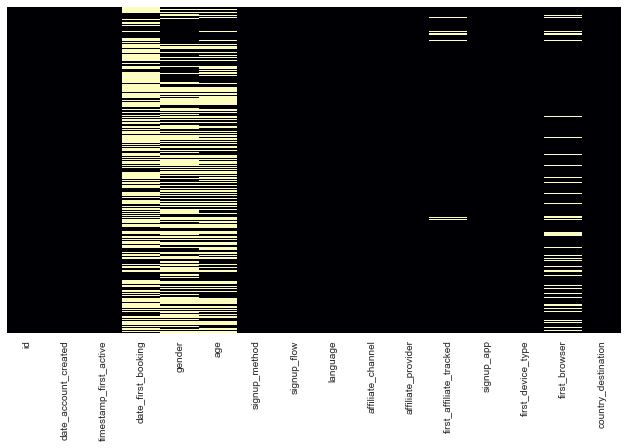

In [364]:
# For all my columns in the user table, visualize which ones have missing values
plt.figure(figsize= (11,6))
sns.heatmap(users.isnull(),yticklabels=False,cbar=False,cmap='magma');

Unfortunately, age and gender have quite a bit of missing values (in yellow). This is unfortunate since both columns I suspect hold some predictive power on the target variable. Down the line, I will think more closely about how to impute these values. For now, I'll remove them. That would cut my dataset from over 200K observations to a bit over 100K observations.

In [365]:
print('Percent of instances with missing values for gender:')
(users[users['gender'].isnull()]['id'].count() / users['id'].count())*100

Percent of instances with missing values for gender:


44.829023991454712

In [366]:
print('Percent of instances with missing values for age:')
(users[users['age'].isnull()]['id'].count() / users['id'].count())*100

Percent of instances with missing values for age:


41.222575673105304

In [367]:
# Clean up the gender column
users.loc[users['gender'].isin(['MALE', 'FEMALE']), 'gender'] = (users[users['gender']
                                                                    .isin(['MALE', 'FEMALE'])]['gender']
                                                                    .apply(lambda x: x.title()))

In [368]:
# Creating a new df that only looks at those columns in which age and gender are not null
clean_users = users[(users['age'].notnull()) & (users['gender'].notnull())].copy()

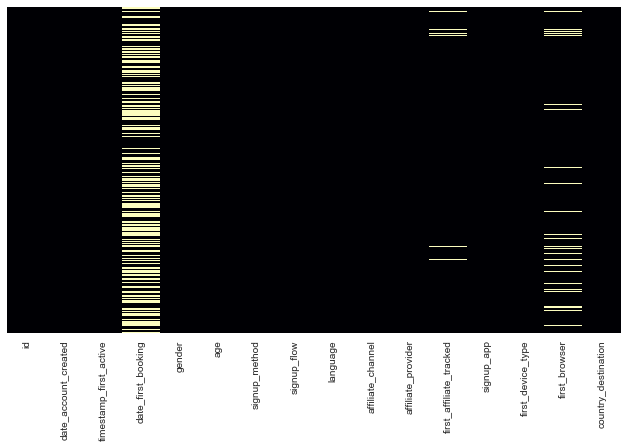

In [369]:
# Visualize my missing data once again
plt.figure(figsize= (11,6))
sns.heatmap(clean_users.isnull(),yticklabels=False,cbar=False,cmap='magma');

In [370]:
# Drop less useful cols such as date_first_booking and first browser (missing values)
clean_users = clean_users[['id', 'date_account_created','timestamp_first_active', 'gender', 
                           'age', 'signup_method', 'signup_flow', 'language',
                           'affiliate_channel', 'affiliate_provider', 'signup_app',
                           'first_device_type', 'country_destination']]

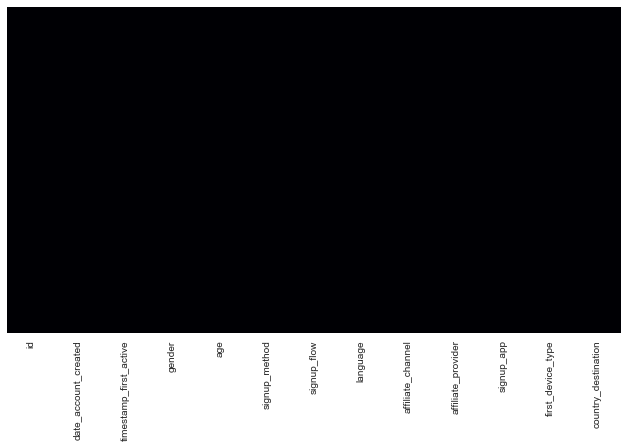

In [371]:
# Visualize if there are any columns with missing data left - should be all good
plt.figure(figsize= (11,6))
sns.heatmap(clean_users.isnull(),yticklabels=False,cbar=False,cmap='magma');

In [372]:
clean_users.head()

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,signup_app,first_device_type,country_destination
1,820tgsjxq7,2011-05-25,20090523174809,Male,38.0,facebook,0,en,seo,google,Web,Mac Desktop,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,Female,56.0,basic,3,en,direct,direct,Web,Windows Desktop,US
3,bjjt8pjhuk,2011-12-05,20091031060129,Female,42.0,facebook,0,en,direct,direct,Web,Mac Desktop,other
6,lsw9q7uk0j,2010-01-02,20100102012558,Female,46.0,basic,0,en,other,craigslist,Web,Mac Desktop,US
7,0d01nltbrs,2010-01-03,20100103191905,Female,47.0,basic,0,en,direct,direct,Web,Mac Desktop,US


In [373]:
# Make date_account_created col into datetime
clean_users['date_account_created'] = pd.to_datetime(clean_users['date_account_created'])

# Make timestamp_first_active into a datetime
clean_users['timestamp_first_active'] = clean_users['timestamp_first_active'].apply(lambda x: str(x)[:8])
clean_users['timestamp_first_active'] = pd.to_datetime(clean_users['timestamp_first_active'], format='%Y%m%d', errors='ignore')

# Calculate new column with the time between account creation and when the user is first active
clean_users['active_created_duration'] = (clean_users['date_account_created'] - clean_users['timestamp_first_active']).dt.days

# Create month and year cols
clean_users['year_created'] = pd.DatetimeIndex(clean_users['date_account_created']).year
clean_users['month_created'] = pd.DatetimeIndex(clean_users['date_account_created']).month

In [374]:
# Rearrange order of columsn
cols_reord = ['id', 'date_account_created', 'year_created', 'month_created', 'timestamp_first_active',
                'active_created_duration', 'gender', 'age', 'signup_method', 'signup_flow', 'language',
                'affiliate_channel', 'affiliate_provider', 'signup_app', 'first_device_type', 'country_destination']

clean_users = clean_users[cols_reord]
clean_users.head()

,id,date_account_created,year_created,month_created,timestamp_first_active,active_created_duration,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,signup_app,first_device_type,country_destination
1,820tgsjxq7,2011-05-25,2011,5,2009-05-23,732,Male,38.0,facebook,0,en,seo,google,Web,Mac Desktop,NDF
2,4ft3gnwmtx,2010-09-28,2010,9,2009-06-09,476,Female,56.0,basic,3,en,direct,direct,Web,Windows Desktop,US
3,bjjt8pjhuk,2011-12-05,2011,12,2009-10-31,765,Female,42.0,facebook,0,en,direct,direct,Web,Mac Desktop,other
6,lsw9q7uk0j,2010-01-02,2010,1,2010-01-02,0,Female,46.0,basic,0,en,other,craigslist,Web,Mac Desktop,US
7,0d01nltbrs,2010-01-03,2010,1,2010-01-03,0,Female,47.0,basic,0,en,direct,direct,Web,Mac Desktop,US


### Independet Variables Exploration

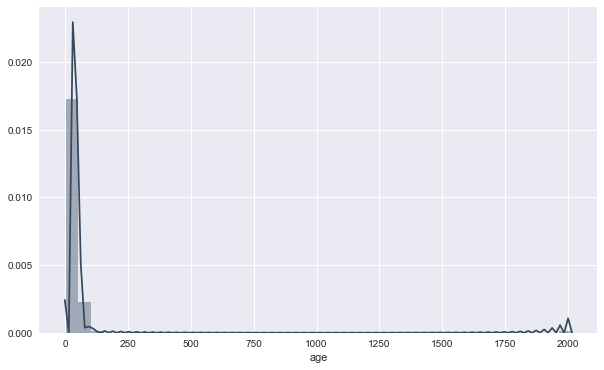

In [375]:
# Visualize the overall distribution of ages
plt.figure(figsize= (10, 6))
sns.distplot(clean_users['age'], bins= 40, color= '#34495e');

Looks like there is a crazy distribution - it's extremely skewed to the right. I'll explore this a bit more.

In [376]:
# What's the max age in the data set?
clean_users['age'].max()

2014.0

In [377]:
# How many users are over the age of 100?
users[users['age'] >= 100].count()

id                         2371
date_account_created       2371
timestamp_first_active     2371
date_first_booking         1330
gender                     1665
age                        2371
signup_method              2371
signup_flow                2371
language                   2371
affiliate_channel          2371
affiliate_provider         2371
first_affiliate_tracked    2321
signup_app                 2371
first_device_type          2371
first_browser              2215
country_destination        2371
dtype: int64

In [378]:
# Over 2300 observations have a strange age. Will do a simple imputation for these using the median age of the dataset
median_age = clean_users['age'].median()
clean_users.loc[clean_users['age'] >= 100, 'age'] = median_age 

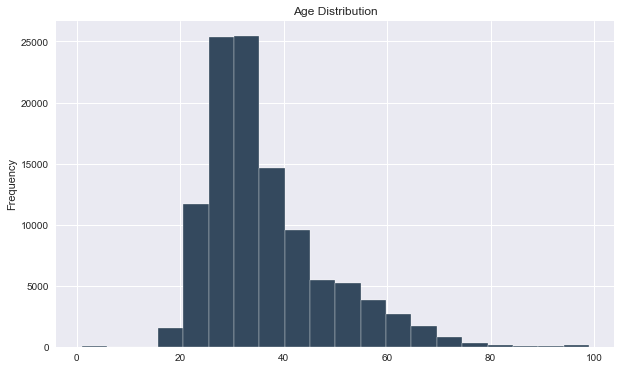

In [379]:
# Trying this again. Visualizing the overall distribution of ages
fig, ax = plt.subplots(figsize= (10, 6))
clean_users['age'].plot(kind= 'hist', bins= 20, edgecolor= 'white', color= "#34495e")

ax.set_title('Age Distribution');

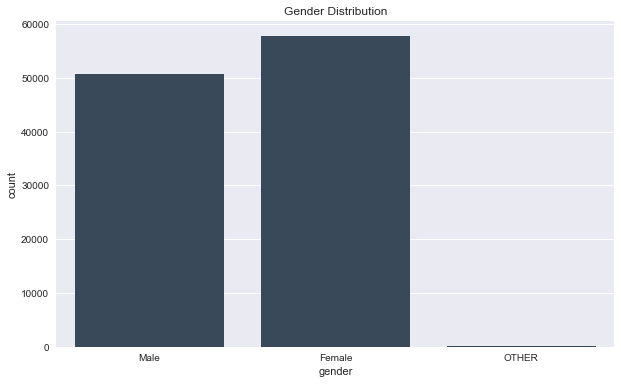

In [380]:
# Plot the count of sexes
fig, ax = plt.subplots(figsize= (10, 6))
sns.countplot(x= 'gender', data= clean_users, palette= ["#34495e"], ax= ax)

ax.set_title('Gender Distribution');

In [381]:
# Remove 'other' gender category
clean_users = clean_users[clean_users['gender'] != 'OTHER']

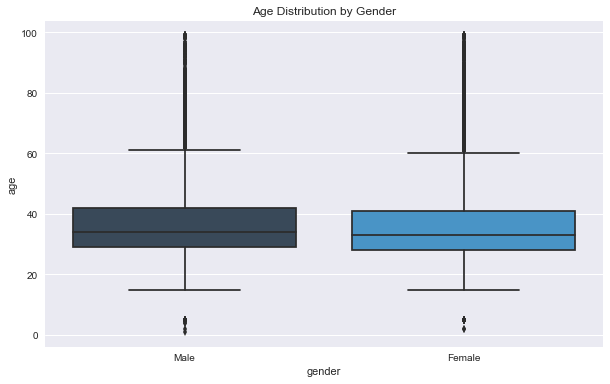

In [382]:
# Visualize the distribution of age for the different sexes
fig, ax = plt.subplots(figsize= (10, 6))
sns.boxplot(x= 'gender', y= 'age', data= clean_users, palette= ["#34495e", "#3498db"], ax= ax)

ax.set_title('Age Distribution by Gender');

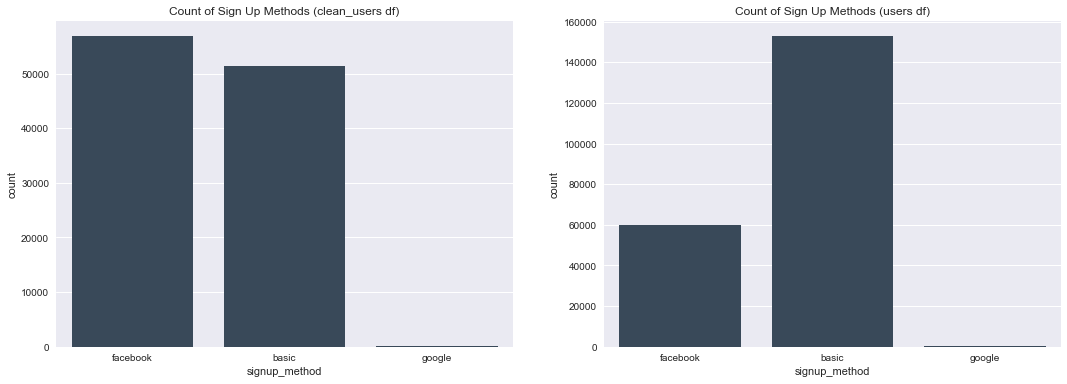

In [383]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (18, 6))

sns.countplot(x= 'signup_method', data= clean_users, palette= ["#34495e"], ax= ax1)
ax1.set_title('Count of Sign Up Methods (clean_users df)')

sns.countplot(x= 'signup_method', data= users, palette= ["#34495e"], ax= ax2)
ax2.set_title('Count of Sign Up Methods (users df)');

If I swap the clean_users data frame for the users dataframe, I can clearly see I've introduced some bias to my data. I'll have to think about this more prior to running predictive models.


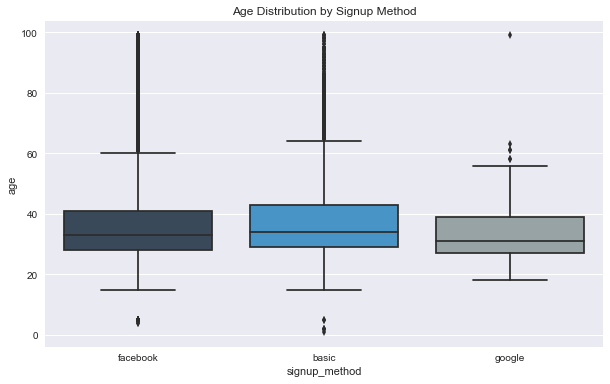

In [384]:
fig, ax = plt.subplots(figsize= (10, 6))
sns.boxplot(x= 'signup_method', y= 'age', data= clean_users, palette= ["#34495e", "#3498db", "#95a5a6"], ax= ax)

ax.set_title('Age Distribution by Signup Method');

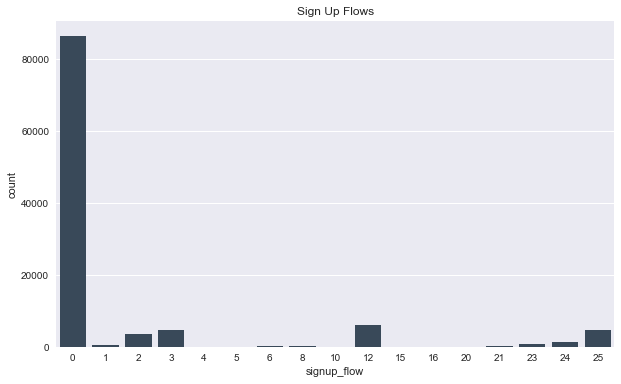

In [385]:
fig, ax = plt.subplots(figsize= (10, 6))
sns.countplot(x= 'signup_flow', data= clean_users, palette= ["#34495e"], ax= ax,)

ax.set_title('Sign Up Flows');

Seems like most people come from sign up flow '0'. Several users sign up on 3, 12, and 25. Not exactly sure if this is a different sign up form or it's the pages navigated prior to signing up, but it could hold some predictive power.

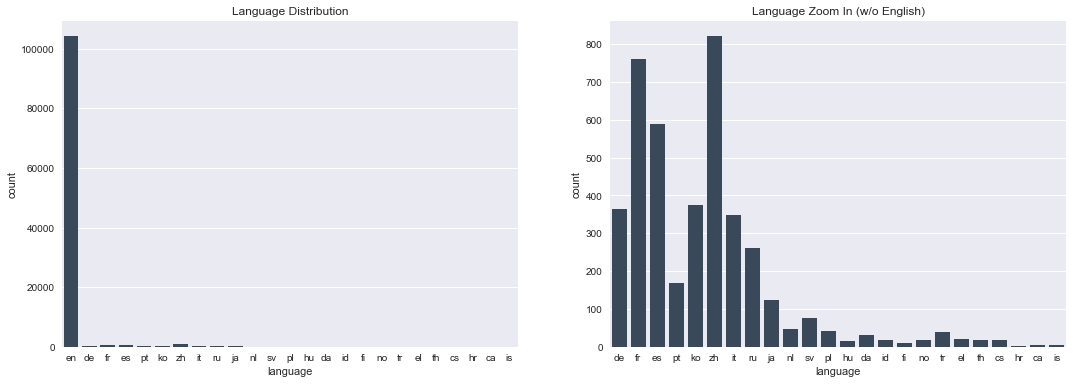

In [386]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (18, 6))
sns.countplot(x= 'language', data= clean_users, palette= ["#34495e"], ax= ax1)
ax1.set_title('Language Distribution')

sns.countplot(x= 'language', data= clean_users[clean_users['language'] != 'en'] , palette= ["#34495e"], ax= ax2);
ax2.set_title('Language Zoom In (w/o English)');

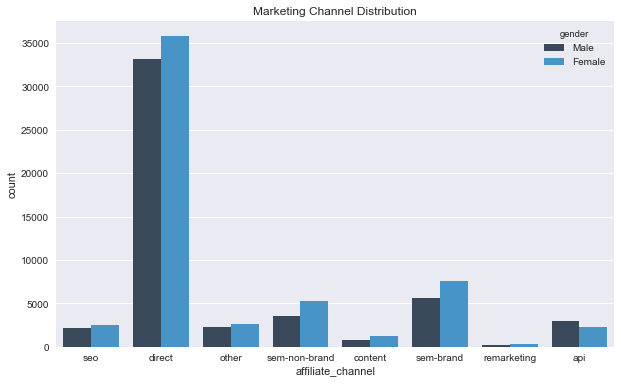

In [387]:
fig, ax = plt.subplots(figsize= (10, 6))
sns.countplot(x= 'affiliate_channel', hue= 'gender', data= clean_users, palette= ["#34495e", "#3498db"], ax= ax)

ax.set_title("Marketing Channel Distribution");

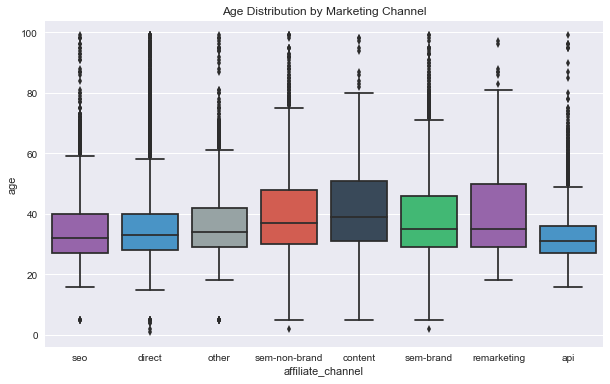

In [388]:
fig, ax = plt.subplots(figsize= (10, 6))
sns.boxplot(x= 'affiliate_channel', y= 'age', data= clean_users, 
            palette= ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"],
            ax= ax)

ax.set_title('Age Distribution by Marketing Channel');

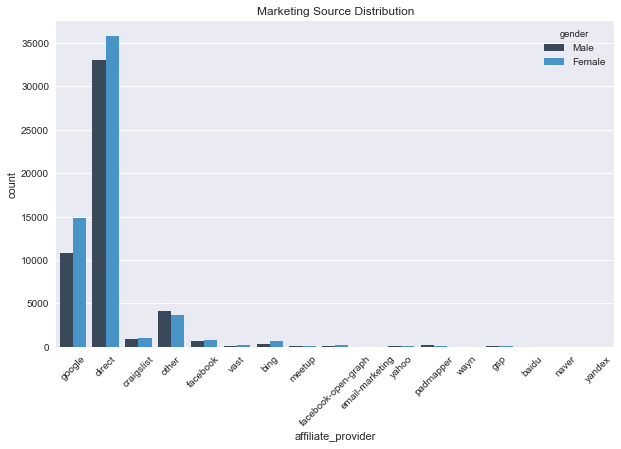

In [389]:
fig, ax = plt.subplots(figsize= (10, 6))
sns.countplot(x= 'affiliate_provider', hue= 'gender', data= clean_users, palette= ["#34495e", "#3498db"], ax= ax)

ax.set_title('Marketing Source Distribution')
plt.xticks(rotation= 45);

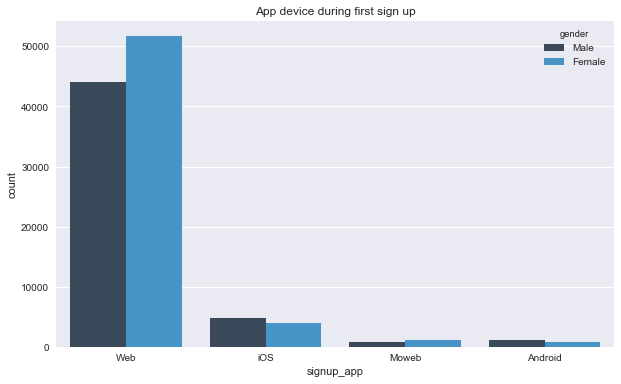

In [390]:
fig, ax = plt.subplots(figsize= (10, 6))
sns.countplot(x= 'signup_app', hue= 'gender', data= clean_users, palette= ["#34495e", "#3498db"], ax= ax)

ax.set_title('App device during first sign up');

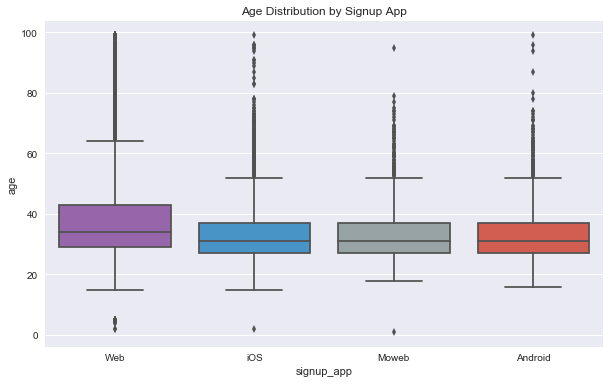

In [391]:
fig, ax = plt.subplots(figsize= (10, 6))
sns.boxplot(x= 'signup_app', y= 'age', data= clean_users, 
            palette= ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"],
            ax= ax)

ax.set_title('Age Distribution by Signup App');

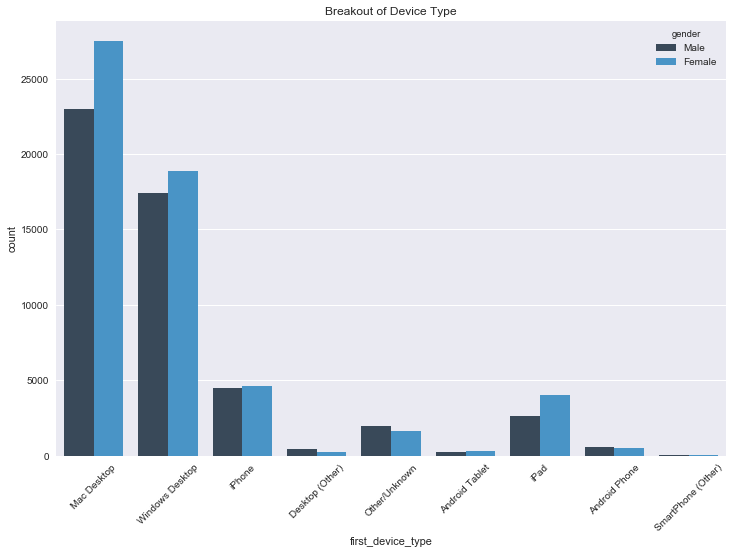

In [392]:
fig, ax = plt.subplots(figsize= (12, 8))
sns.countplot(x= 'first_device_type', hue= 'gender', data= clean_users, palette= ["#34495e", "#3498db"], ax= ax)

ax.set_title('Breakout of Device Type')
plt.xticks(rotation= 45);

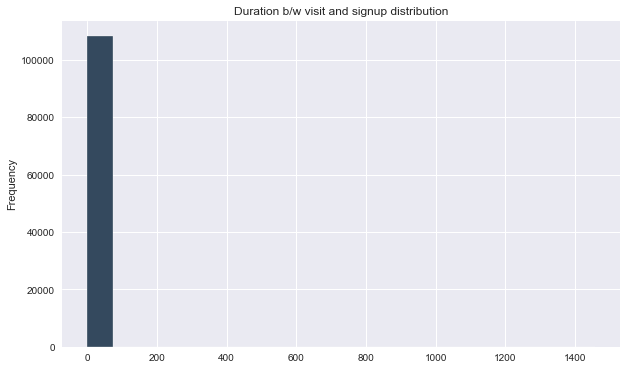

In [393]:
fig, ax = plt.subplots(figsize= (10, 6))
clean_users['active_created_duration'].plot(kind= 'hist', bins= 20, edgecolor= 'white', color= "#34495e")

ax.set_title('Duration b/w visit and signup distribution');

### Target Variable Exploration

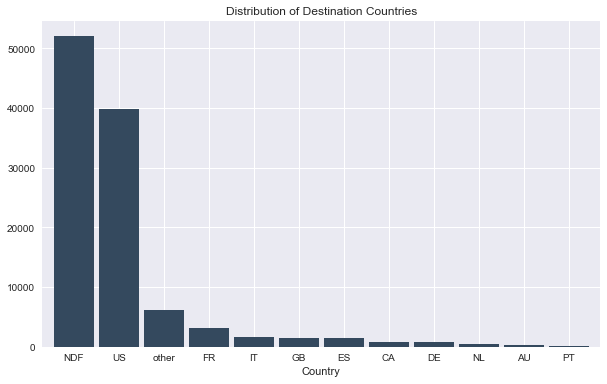

In [394]:
# Look at distribution of target variable
fig, ax = plt.subplots(figsize= (10,6))
clean_users['country_destination'].value_counts().plot(kind= 'bar', ax= ax, color= ['#34495e'], width= 0.9)

ax.set_xlabel('Country')
ax.set_title('Distribution of Destination Countries')
plt.xticks(rotation= 0);

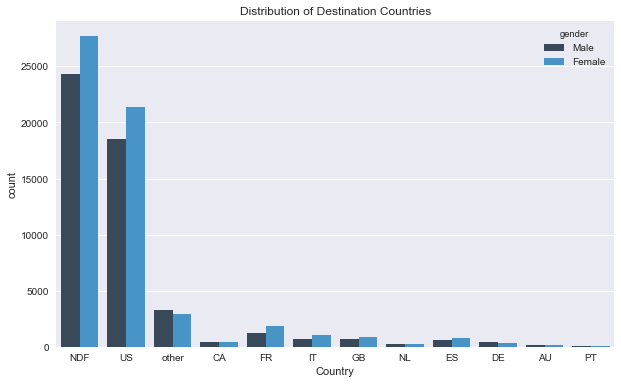

In [395]:
# Look at distribution of target variable
fig, ax = plt.subplots(figsize= (10,6))
sns.countplot(x= 'country_destination', hue= 'gender', data= clean_users, palette= ["#34495e", "#3498db"], ax= ax)

ax.set_xlabel('Country')
ax.set_title('Distribution of Destination Countries')
plt.xticks(rotation= 0);

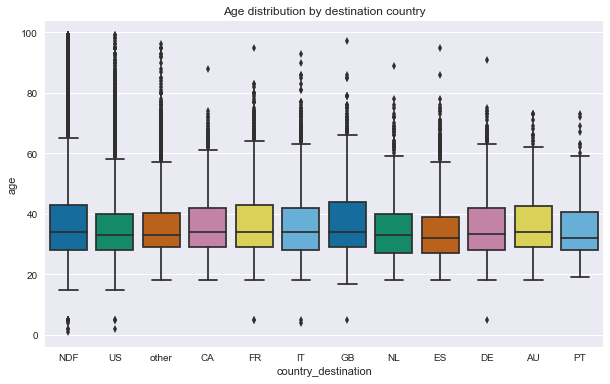

In [396]:
# Distribution of ages for the different destinations
fig, ax = plt.subplots(figsize= (10,6))
sns.boxplot(x= 'country_destination', y= 'age', palette= 'colorblind', data= clean_users, ax= ax)

ax.set_title('Age distribution by destination country');

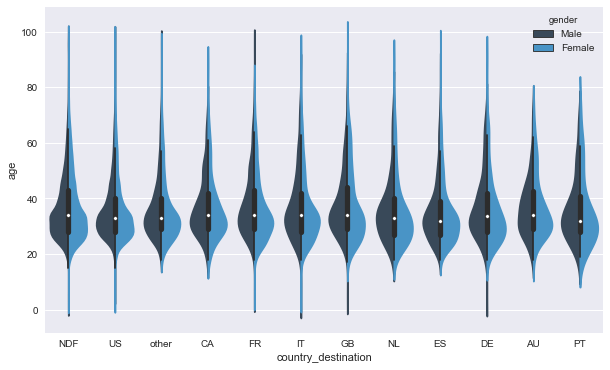

In [397]:
# Adding a gender dimension
fig, ax = plt.subplots(figsize= (10,6))
sns.violinplot(x= 'country_destination', y= 'age', hue= 'gender', split= True, 
               palette= ["#34495e", "#3498db"], data= clean_users, ax= ax);

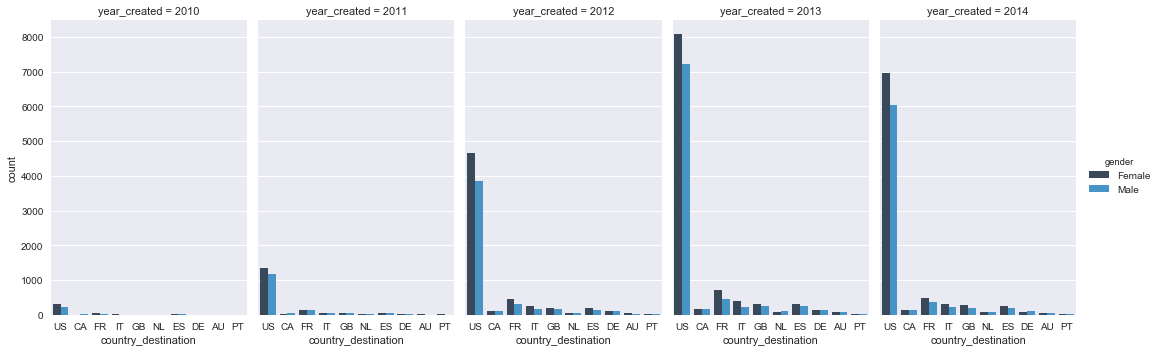

In [398]:
# Look at the evolution of destination countries by year. Big ramp up of volume as part of Airbnb's growth
sns.factorplot(x="country_destination", hue="gender",
               col="year_created", data=clean_users[~clean_users['country_destination'].isin(['NDF','other'])], 
               kind="count", palette= ["#34495e", "#3498db"], size=5, aspect=.6);

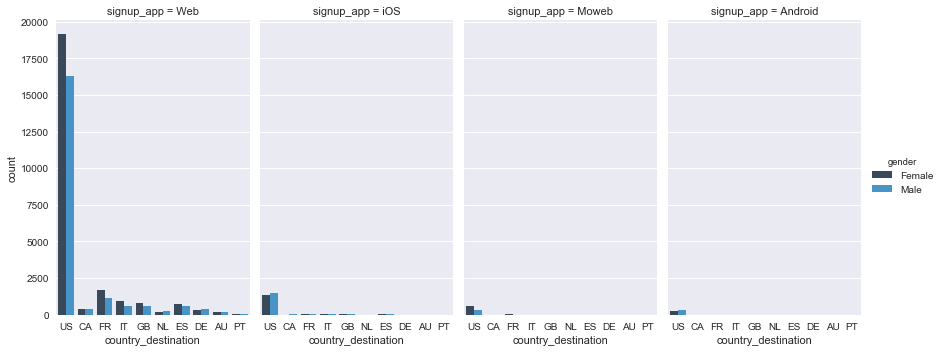

In [399]:
sns.factorplot(x="country_destination", hue="gender",
               col="signup_app", data=clean_users[~clean_users['country_destination'].isin(['NDF','other'])], 
               kind="count", palette= ["#34495e", "#3498db"], size=5, aspect=.6);

### Sessions Table

In [400]:
sessions.head(10)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
5,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,7703.0
6,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,115.0
7,d1mm9tcy42,personalize,data,wishlist_content_update,Windows Desktop,831.0
8,d1mm9tcy42,index,view,view_search_results,Windows Desktop,20842.0
9,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,683.0


In [401]:
sessions.device_type.value_counts()

Mac Desktop                         3594286
Windows Desktop                     2658539
iPhone                              2105031
Android Phone                        839637
iPad Tablet                          683414
Android App Unknown Phone/Tablet     273652
-unknown-                            211279
Tablet                               139886
Linux Desktop                         28373
Chromebook                            22348
iPodtouch                              8198
Windows Phone                          2047
Blackberry                              979
Opera Phone                              68
Name: device_type, dtype: int64

In [402]:
# Create a pivot table so that each column is a device used, and sum up total time on that device
time_by_device = (pd.pivot_table(sessions,
                      index= ['user_id'],
                      columns= ['device_type'],
                      values= 'secs_elapsed',
                      aggfunc= sum,
                      fill_value= 0)
                      .reset_index())

In [403]:
# Create a total time column
time_by_device['total_time'] = time_by_device.sum(axis= 1)
time_by_device.head()

device_type,user_id,-unknown-,Android App Unknown Phone/Tablet,Android Phone,Blackberry,Chromebook,Linux Desktop,Mac Desktop,Opera Phone,Tablet,Windows Desktop,Windows Phone,iPad Tablet,iPhone,iPodtouch,total_time
0,00023iyk9l,0,0,0,0,0,0,295642,0,0,0,0,0,572254,0,867896
1,0010k6l0om,0,0,0,0,0,0,586543,0,0,0,0,0,0,0,586543
2,001wyh0pz8,0,282965,0,0,0,0,0,0,0,0,0,0,0,0,282965
3,0028jgx1x1,297010,0,0,0,0,0,0,0,0,0,0,0,0,0,297010
4,002qnbzfs5,203511,0,0,0,0,0,0,0,0,0,0,0,6283569,0,6487080


In [404]:
# Transform total times into percetages
device_columns = time_by_device.columns[1:-2]

def pct_calc(time_by_device, total_time):
      return time_by_device/total_time if total_time > 0 else None

for col in device_columns:
        time_by_device[col+'_pct'] = time_by_device.apply(lambda row: pct_calc(row[col], row['total_time']), axis=1)
        
# Hat/tip for this logic in this kaggle kernel: https://www.kaggle.com/paullo0106/comebine-users-and-sessions-data

In [405]:
time_by_device.head()

device_type,user_id,-unknown-,Android App Unknown Phone/Tablet,Android Phone,Blackberry,Chromebook,Linux Desktop,Mac Desktop,Opera Phone,Tablet,...,Blackberry_pct,Chromebook_pct,Linux Desktop_pct,Mac Desktop_pct,Opera Phone_pct,Tablet_pct,Windows Desktop_pct,Windows Phone_pct,iPad Tablet_pct,iPhone_pct
0,00023iyk9l,0,0,0,0,0,0,295642,0,0,...,0.0,0.0,0.0,0.340642,0.0,0.0,0.0,0.0,0.0,0.659358
1,0010k6l0om,0,0,0,0,0,0,586543,0,0,...,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000
2,001wyh0pz8,0,282965,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
3,0028jgx1x1,297010,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
4,002qnbzfs5,203511,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.968628


In [406]:
sessions.action_type.value_counts()

view                3560902
data                2103770
click               1996183
-unknown-           1031170
submit               623357
message_post          87103
partner_callback      19132
booking_request       18773
modify                 1139
booking_response          4
Name: action_type, dtype: int64

In [407]:
count_of_action_types = (pd.pivot_table(sessions,
                      index= ['user_id'],
                      columns= ['action_type'],
                      values= 'secs_elapsed',
                      aggfunc= len,
                      fill_value= 0)
                      .reset_index())

In [408]:
count_of_action_types.head()

action_type,user_id,-unknown-,booking_request,booking_response,click,data,message_post,modify,partner_callback,submit,view
0,00023iyk9l,0,1,0,4,9,1,0,1,0,21
1,0010k6l0om,5,0,0,16,9,0,0,1,0,17
2,001wyh0pz8,6,0,0,66,2,0,0,0,3,8
3,0028jgx1x1,1,0,0,9,5,0,0,0,1,15
4,002qnbzfs5,184,1,0,140,140,16,0,0,15,216


In [409]:
key_action_types = count_of_action_types[['user_id', 'view', 'click', 'data', 'submit', 'booking_request']]

In [410]:
key_action_types.head()

action_type,user_id,view,click,data,submit,booking_request
0,00023iyk9l,21,4,9,0,1
1,0010k6l0om,17,16,9,0,0
2,001wyh0pz8,8,66,2,3,0
3,0028jgx1x1,15,9,5,1,0
4,002qnbzfs5,216,140,140,15,1


In [411]:
# Calculate some conversion rates - this could be a useful signal regarding which is a 'higher quality' user
key_action_types['click_through_rate'] = key_action_types['click'] / key_action_types['view'] 
key_action_types['cvr1'] = key_action_types['submit'] / key_action_types['click']
key_action_types['cvr2'] = key_action_types['booking_request'] / key_action_types['click']

/Users/rteran/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/rteran/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/rteran/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [412]:
key_action_types.head()

action_type,user_id,view,click,data,submit,booking_request,click_through_rate,cvr1,cvr2
0,00023iyk9l,21,4,9,0,1,0.190476,0.000000,0.250000
1,0010k6l0om,17,16,9,0,0,0.941176,0.000000,0.000000
2,001wyh0pz8,8,66,2,3,0,8.250000,0.045455,0.000000
3,0028jgx1x1,15,9,5,1,0,0.600000,0.111111,0.000000
4,002qnbzfs5,216,140,140,15,1,0.648148,0.107143,0.007143


In [413]:
# Inner join the two new session-based tables together
pivoted_session_data = pd.merge(time_by_device, key_action_types, how= 'inner', on= 'user_id')
pivoted_session_data.head(10)

,user_id,-unknown-,Android App Unknown Phone/Tablet,Android Phone,Blackberry,Chromebook,Linux Desktop,Mac Desktop,Opera Phone,Tablet,...,iPad Tablet_pct,iPhone_pct,view,click,data,submit,booking_request,click_through_rate,cvr1,cvr2
0,00023iyk9l,0,0,0,0,0,0,295642,0,0,...,0.0,0.659358,21,4,9,0,1,0.190476,0.000000,0.250000
1,0010k6l0om,0,0,0,0,0,0,586543,0,0,...,0.0,0.000000,17,16,9,0,0,0.941176,0.000000,0.000000
2,001wyh0pz8,0,282965,0,0,0,0,0,0,0,...,0.0,0.000000,8,66,2,3,0,8.250000,0.045455,0.000000
3,0028jgx1x1,297010,0,0,0,0,0,0,0,0,...,0.0,0.000000,15,9,5,1,0,0.600000,0.111111,0.000000
4,002qnbzfs5,203511,0,0,0,0,0,0,0,0,...,0.0,0.968628,216,140,140,15,1,0.648148,0.107143,0.007143
5,0031awlkjq,0,0,0,0,0,0,0,0,0,...,0.0,1.000000,3,0,1,0,0,0.000000,NaN,NaN
6,0035hobuyj,0,0,0,0,0,0,5724670,0,0,...,0.0,0.000000,55,206,41,4,0,3.745455,0.019417,0.000000
7,00378ocvlh,0,0,0,0,0,0,1827164,0,0,...,0.0,0.000000,36,5,4,5,0,0.138889,1.000000,0.000000
8,00389675gq,0,0,236259,0,0,0,0,0,0,...,0.0,0.000000,74,22,34,8,0,0.297297,0.363636,0.000000
9,003iamz20l,0,0,0,0,0,0,0,0,0,...,1.0,0.000000,59,47,43,1,0,0.796610,0.021277,0.000000


### Join user table with pivoted session data

In [414]:
df = pd.merge(clean_users, pivoted_session_data, how= 'inner', left_on= ['id'], right_on= ['user_id'])

In [415]:
df.head()

,id,date_account_created,year_created,month_created,timestamp_first_active,active_created_duration,gender,age,signup_method,signup_flow,...,iPad Tablet_pct,iPhone_pct,view,click,data,submit,booking_request,click_through_rate,cvr1,cvr2
0,d1mm9tcy42,2014-01-01,2014,1,2014-01-01,0,Male,62.0,basic,0,...,0.000000,0.000000,25,20,35,1,0,0.800000,0.050000,0.0
1,xwxei6hdk4,2014-01-01,2014,1,2014-01-01,0,Female,32.0,facebook,0,...,0.016307,0.983693,1,1,1,2,0,1.000000,2.000000,0.0
2,qtw88d9pbl,2014-01-01,2014,1,2014-01-01,0,Male,25.0,basic,0,...,0.000000,0.000000,76,89,78,11,0,1.171053,0.123596,0.0
3,awiurksqr3,2014-01-01,2014,1,2014-01-01,0,Female,32.0,facebook,0,...,0.001329,0.998671,2,1,1,2,0,0.500000,2.000000,0.0
4,cuxu2kbaep,2014-01-01,2014,1,2014-01-01,0,Male,30.0,basic,0,...,0.209340,0.000000,0,0,1,1,0,NaN,inf,NaN


In [416]:
print("Number of observations for the new dataframe is: ")
len(df)

Number of observations for the new dataframe is: 


34489

In [417]:
print("Fraction of previous user dataframe observations: ")
(len(df) / len(clean_users)) * 100

Fraction of previous user dataframe observations: 


31.819356029153983